In [12]:
import pywt
import cv2
import numpy as np

# This function does the coefficient fusing according to the fusion method
def fuseCoeff(cooef1, cooef2, method):
    if method == 'mean':
        cooef = (cooef1 + cooef2) / 2
    elif method == 'min':
        cooef = np.minimum(cooef1, cooef2)
    elif method == 'max':
        cooef = np.maximum(cooef1, cooef2)
    else:
        cooef = []
    return cooef

# Params
FUSION_METHOD = 'mean'  # Can be 'min' || 'max || anything you choose according theory

# Read the two images in color
I1 = cv2.imread('book1.jpg', cv2.IMREAD_COLOR)
I2 = cv2.imread('book2.jpg', cv2.IMREAD_COLOR)

# Check if images are loaded correctly
if I1 is None:
    print("Error: Image projpic1.jpg not found or unable to load.")
elif I2 is None:
    print("Error: Image projpic2.jpg not found or unable to load.")
else:
    print("Images loaded successfully.")
    # We need to have both images the same size
    I2 = cv2.resize(I2, (I1.shape[1], I1.shape[0]))  # Resize I2 to match I1's dimensions

    ## Fusion algo

    # First: Do wavelet transform on each color channel of each image
    wavelet = 'db1'
    fused_channels = []
    for channel in range(3):  # Assuming the images have 3 color channels (B, G, R)
        cooef1 = pywt.wavedec2(I1[:, :, channel], wavelet,level=3)
        cooef2 = pywt.wavedec2(I2[:, :, channel], wavelet,level=3)

        # Second: for each level in both images do the fusion according to the desired option
        fusedCooef = []
        for i in range(len(cooef1) - 1):
            # The first values in each decomposition are the approximation values of the top level
            if i == 0:
                fusedCooef.append(fuseCoeff(cooef1[0], cooef2[0], FUSION_METHOD))
            else:
                # For the rest of the levels we have tuples with 3 coefficients
                c1 = fuseCoeff(cooef1[i][0], cooef2[i][0], FUSION_METHOD)
                c2 = fuseCoeff(cooef1[i][1], cooef2[i][1], FUSION_METHOD)
                c3 = fuseCoeff(cooef1[i][2], cooef2[i][2], FUSION_METHOD)
                fusedCooef.append((c1, c2, c3))

        # Third: After we fused the coefficients we need to transform back to get the image
        fused_channel = pywt.waverec2(fusedCooef, wavelet)
        fused_channels.append(fused_channel)

    # Merge the fused color channels back into a single image
    fusedImage = cv2.merge(fused_channels)

    # Fourth: Normalize values to be in uint8
    fusedImage = np.multiply(np.divide(fusedImage - np.min(fusedImage), (np.max(fusedImage) - np.min(fusedImage))), 255)
    fusedImage = fusedImage.astype(np.uint8)

    # Fifth: Show image
    cv2.imshow("win", fusedImage)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

Images loaded successfully.


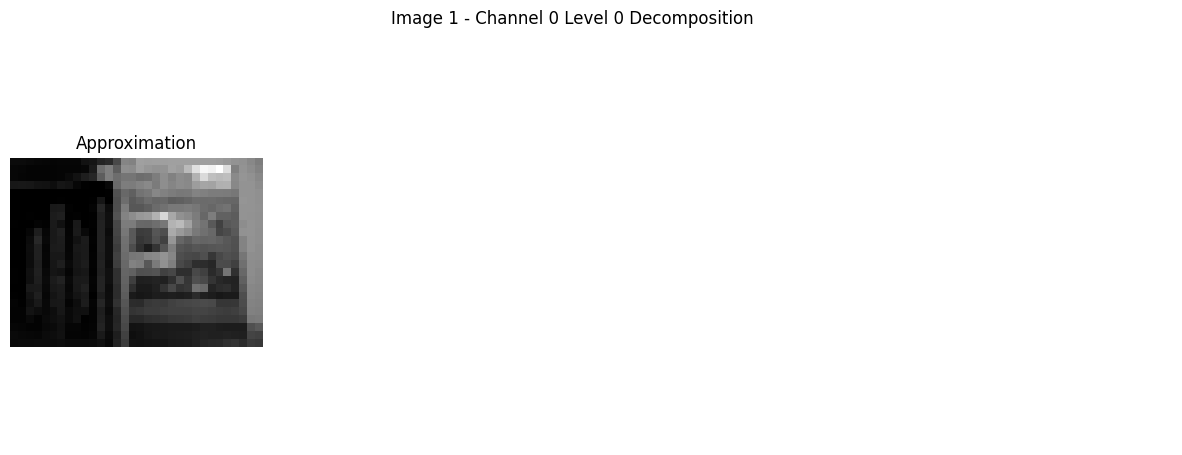

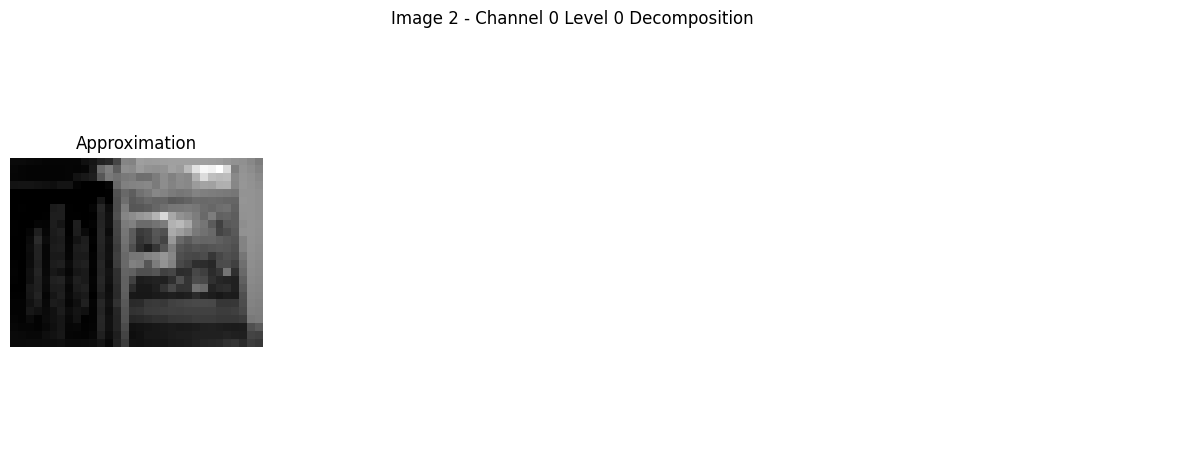

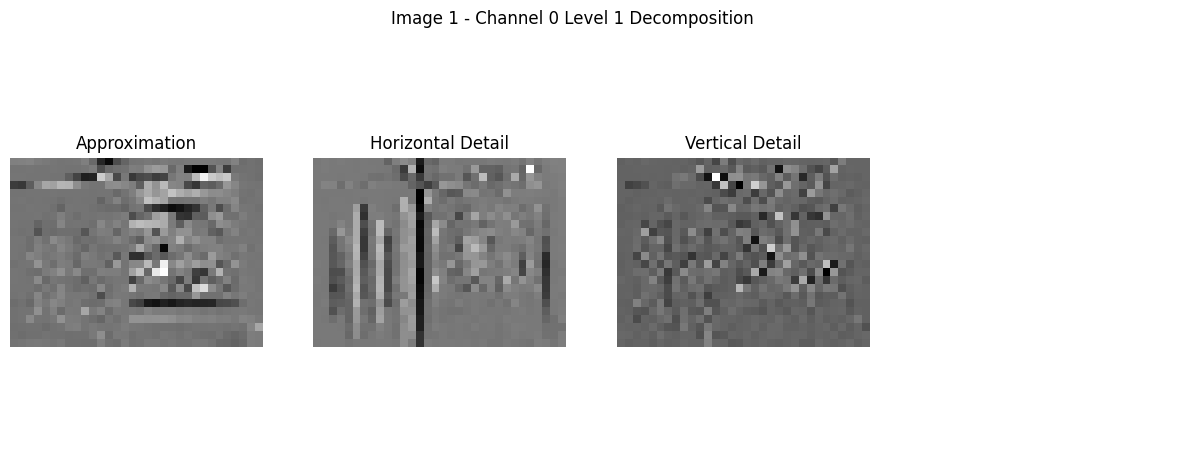

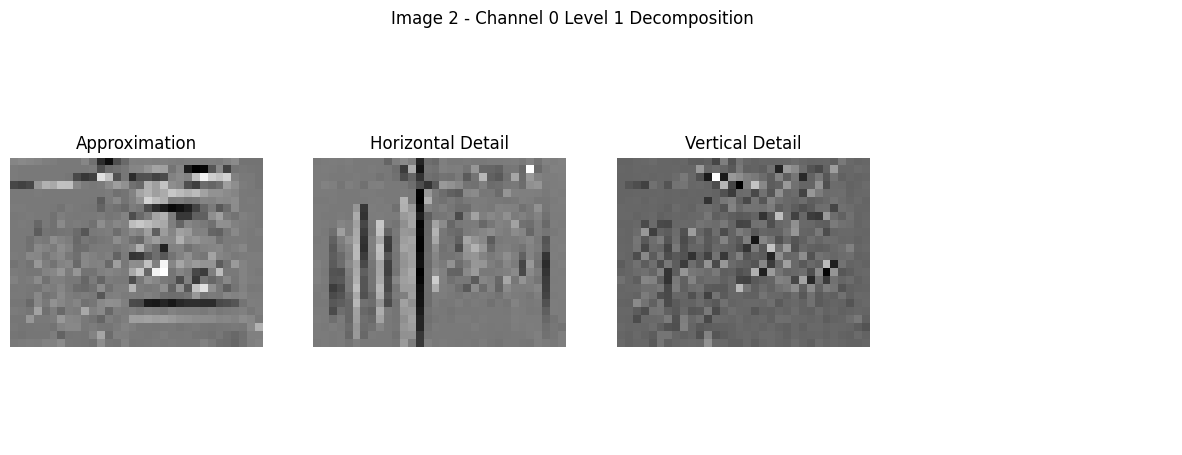

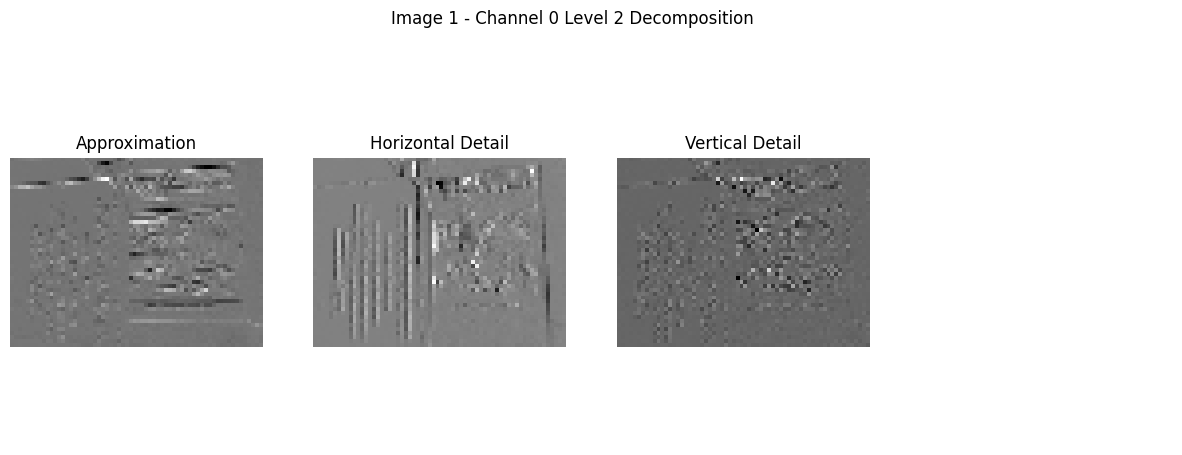

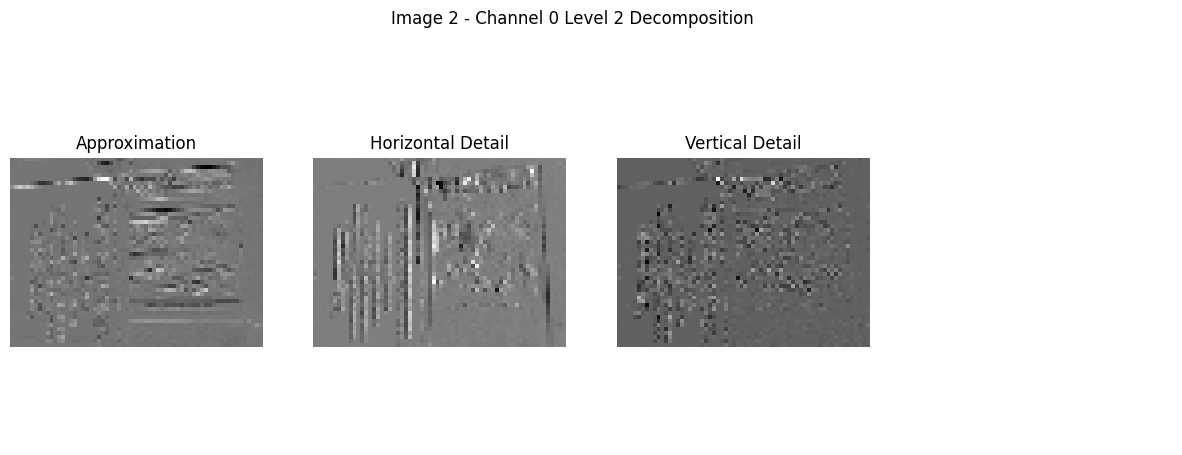

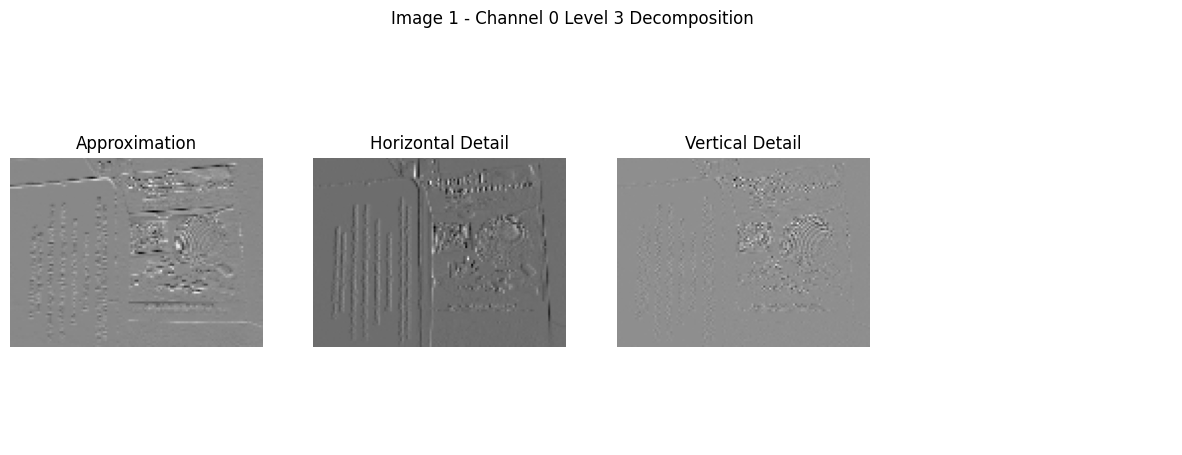

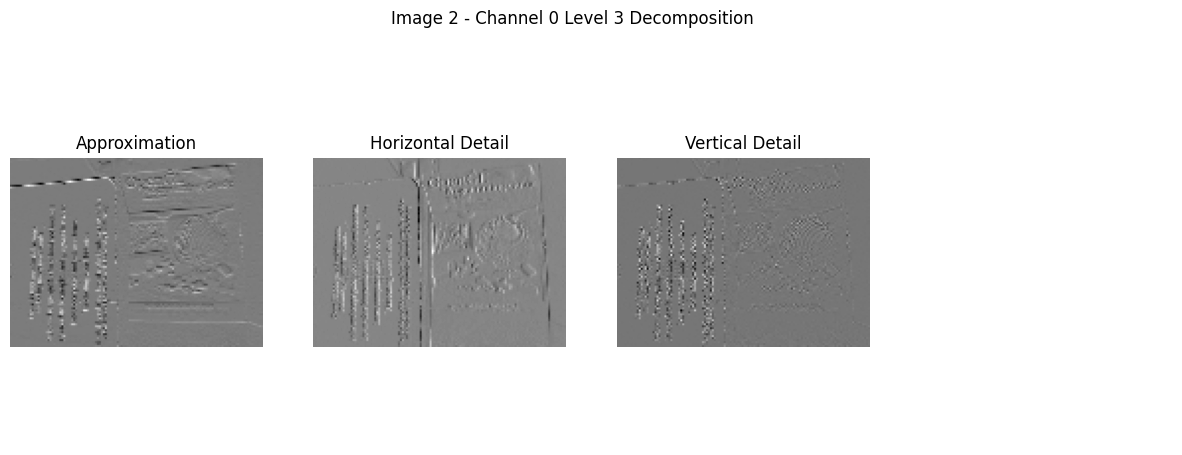

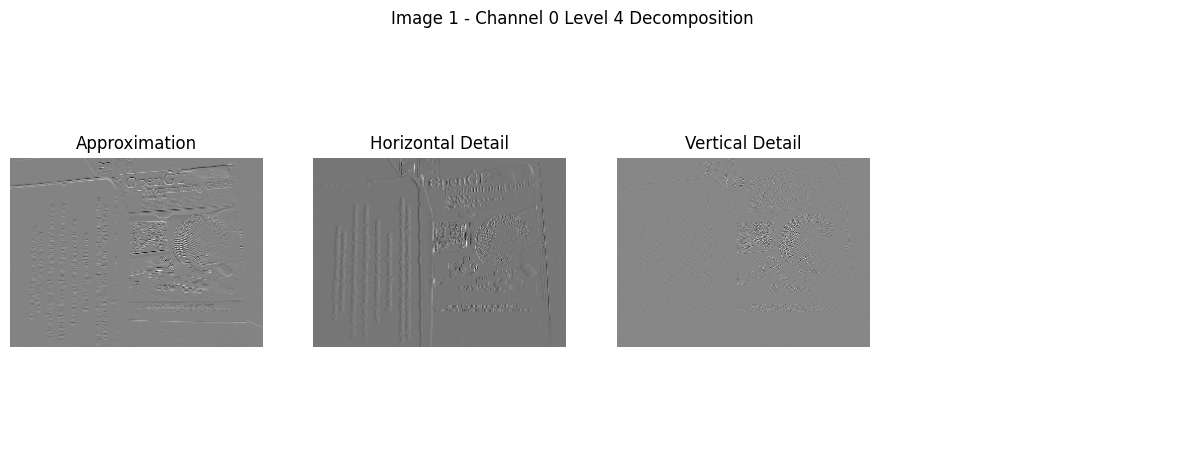

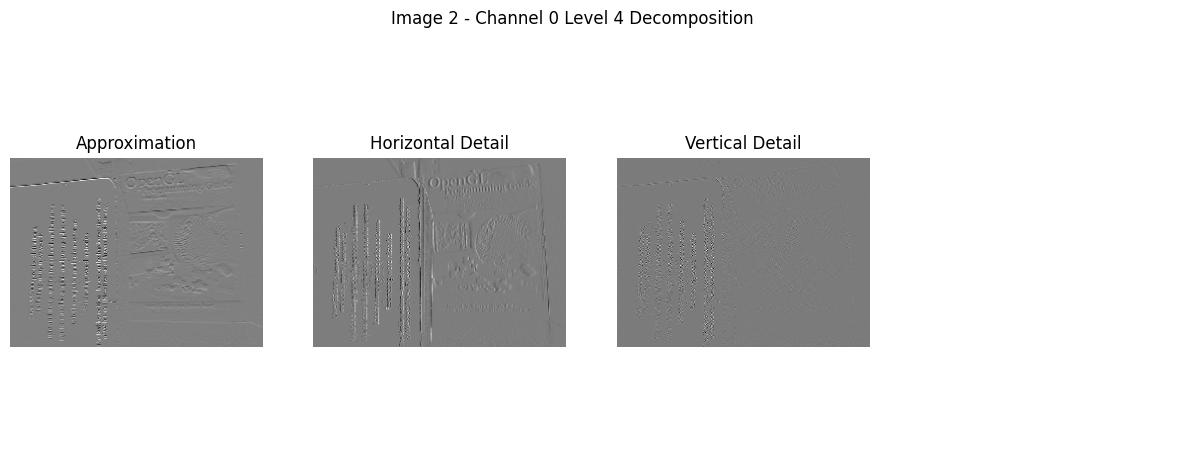

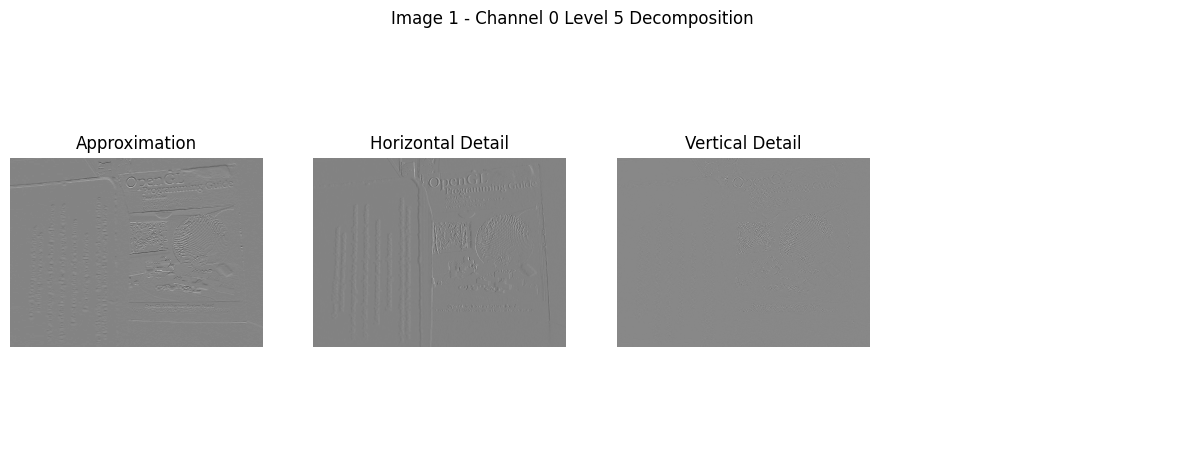

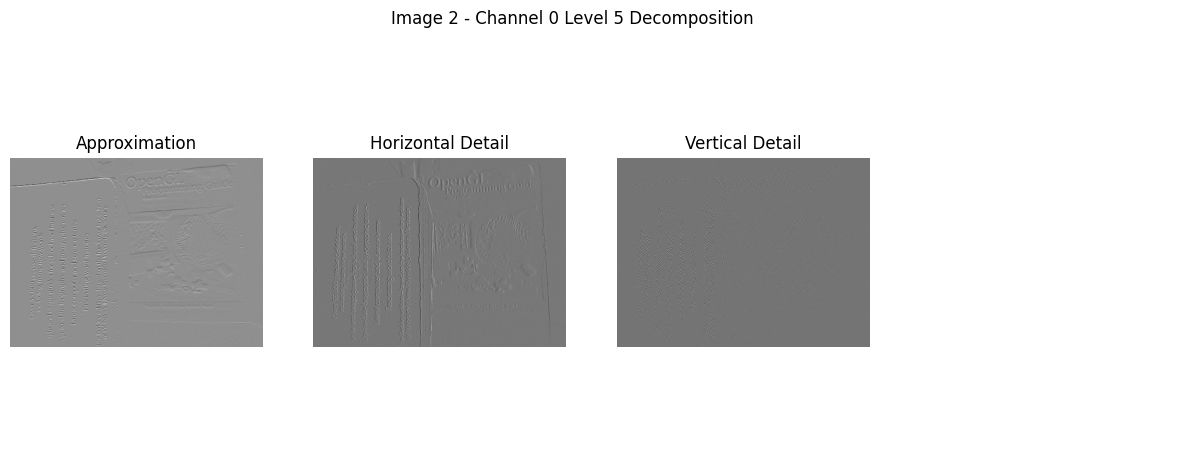

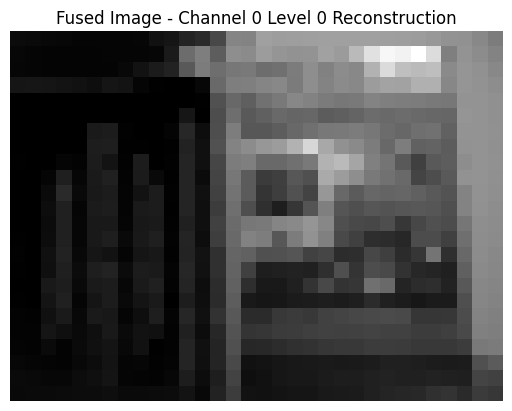

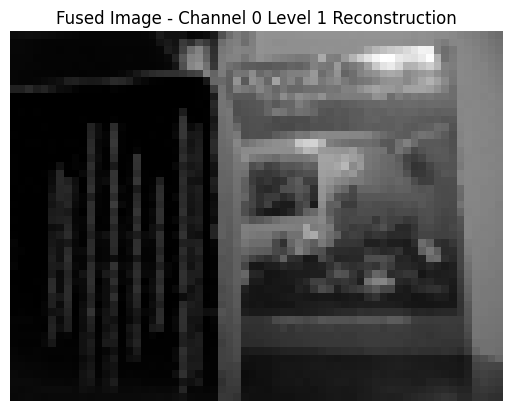

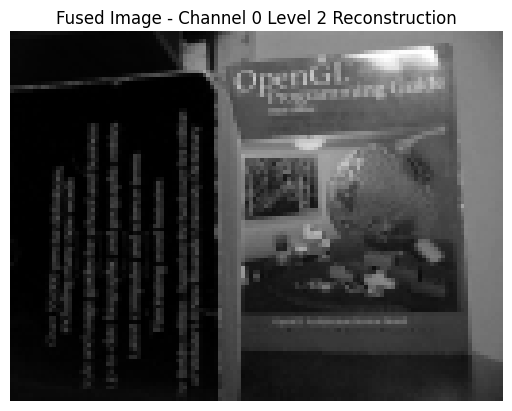

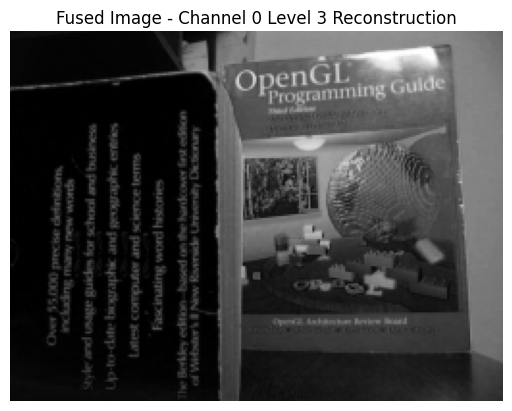

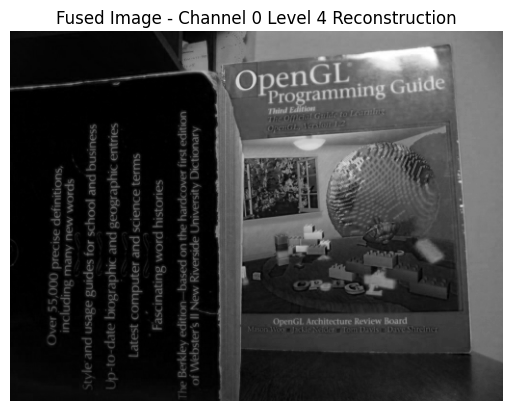

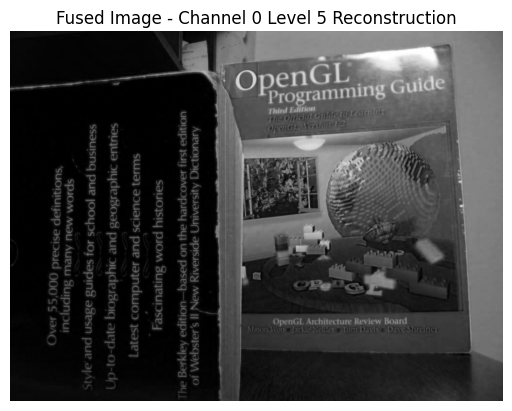

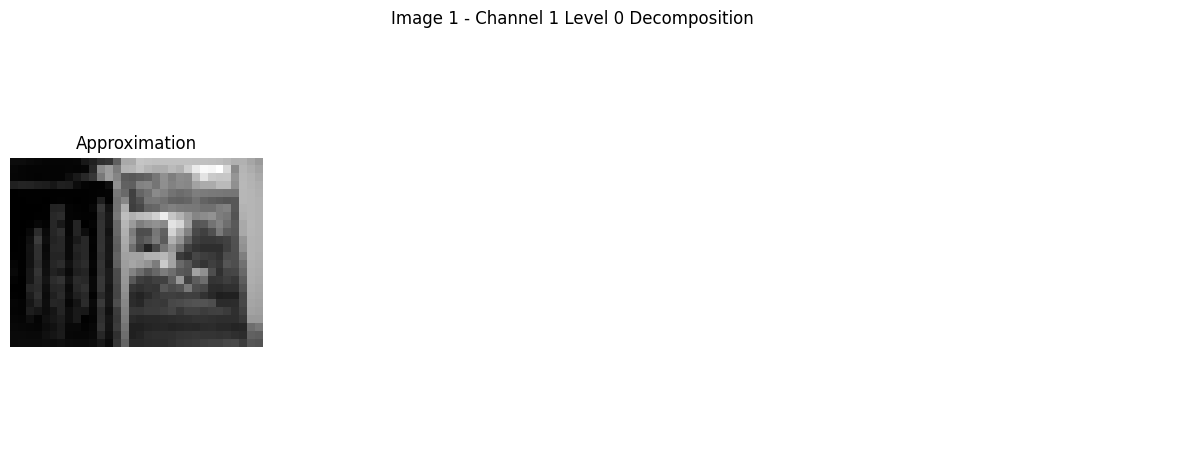

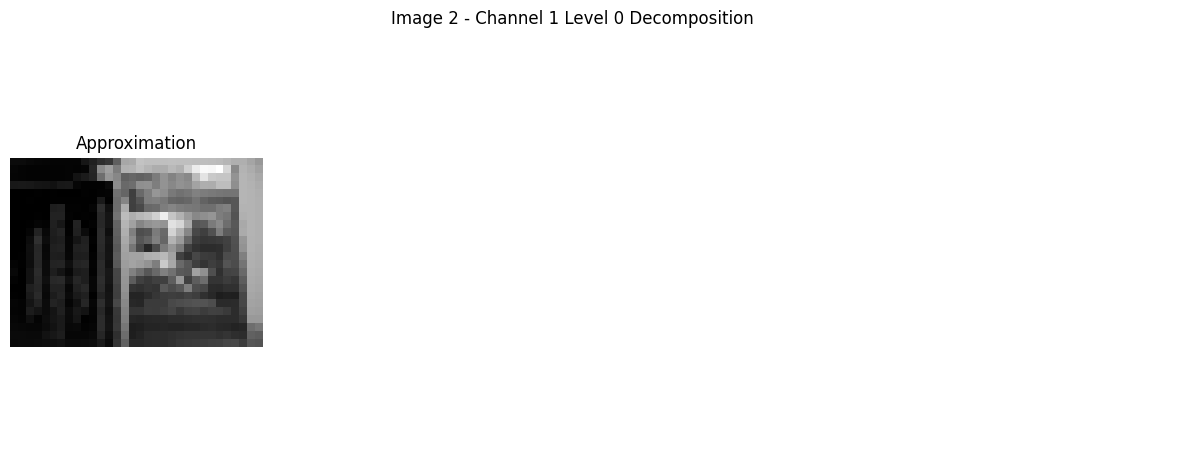

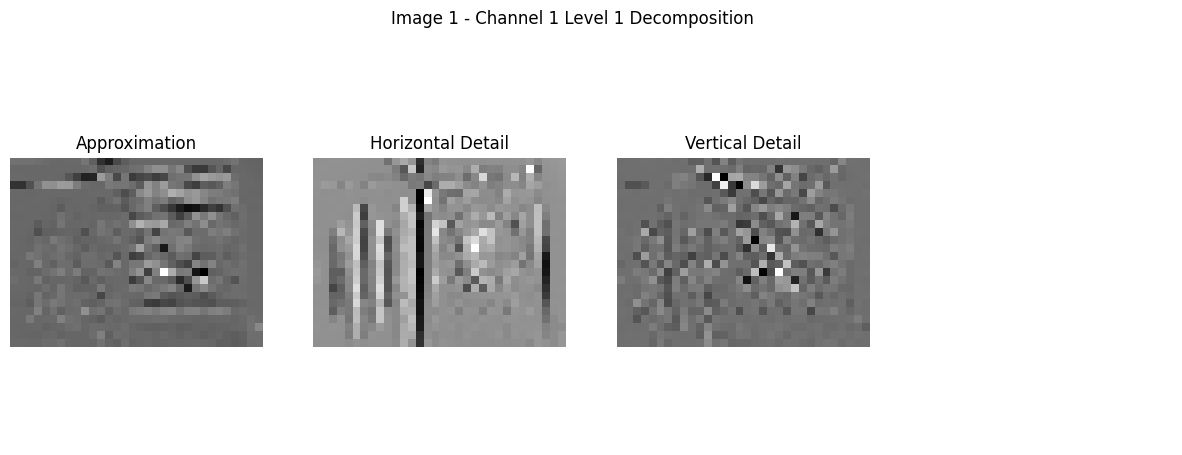

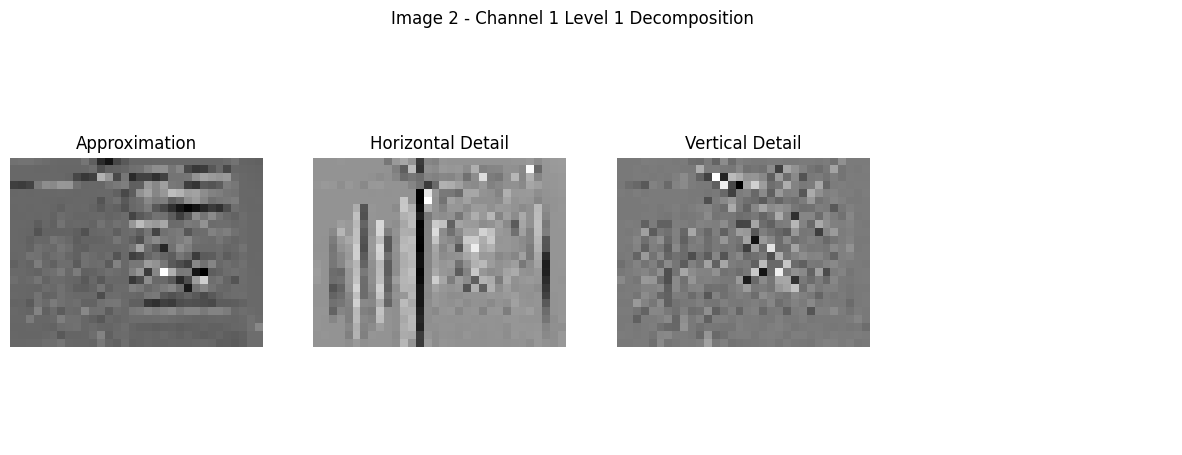

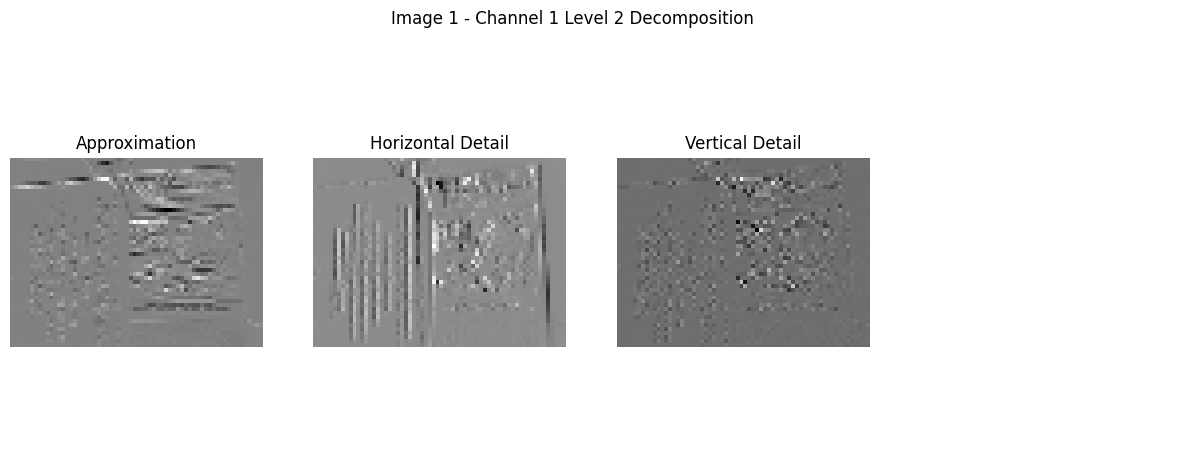

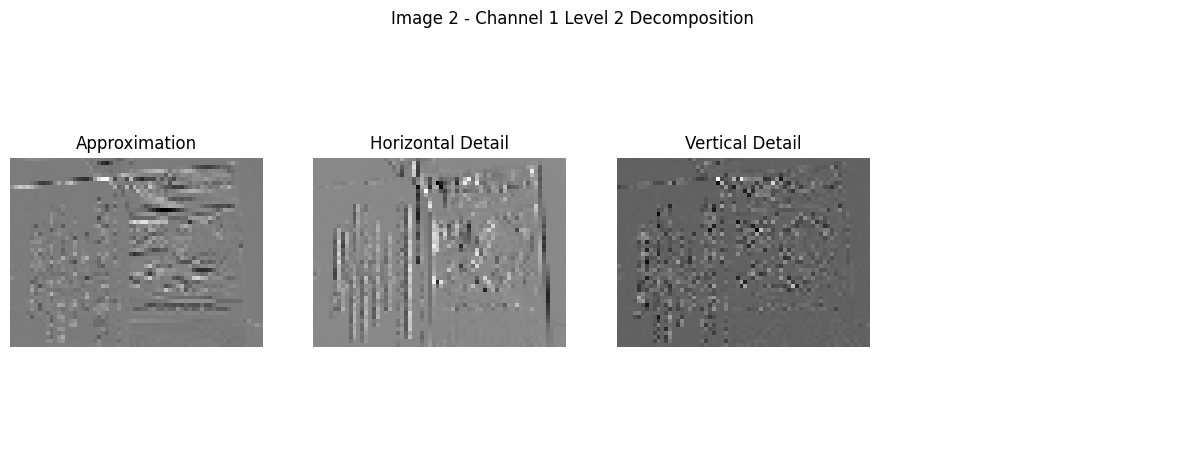

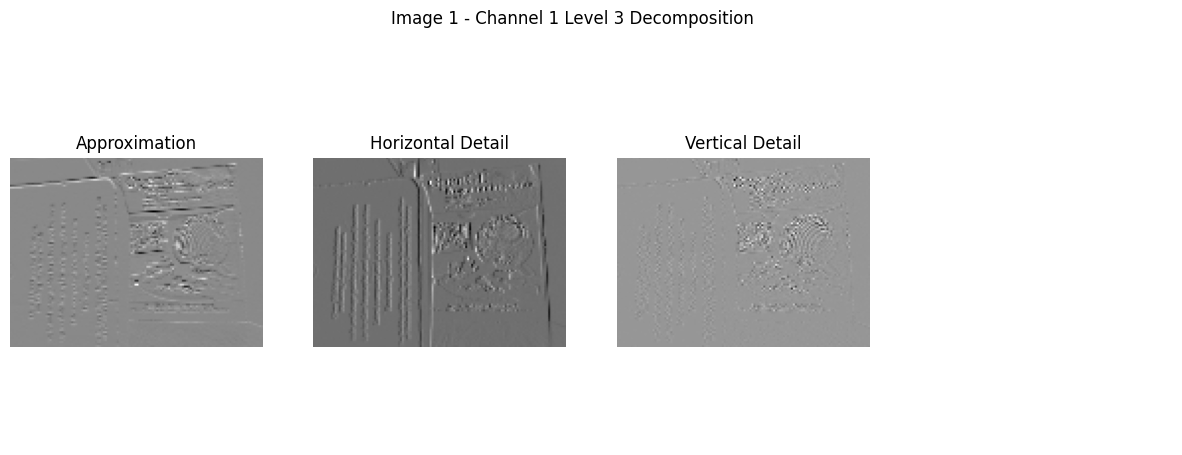

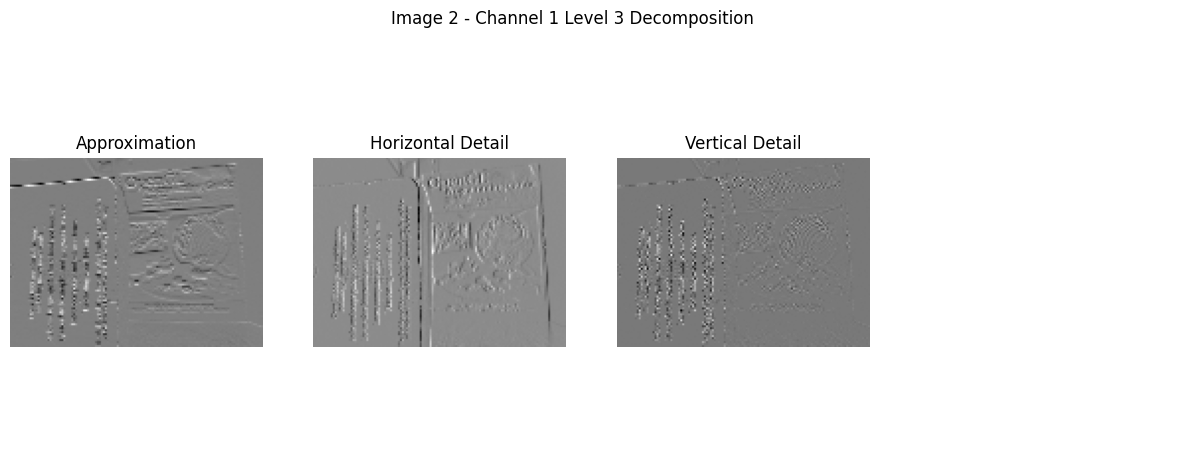

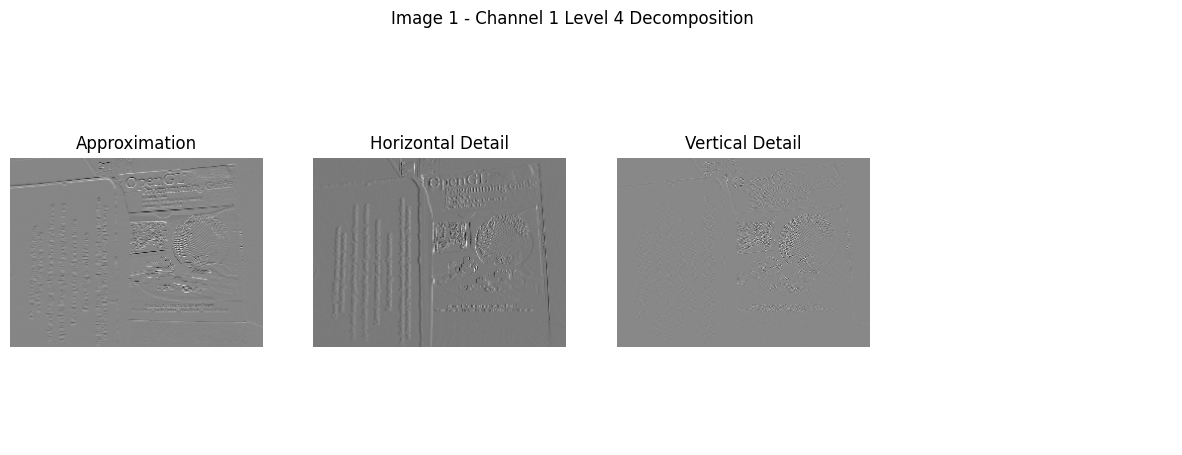

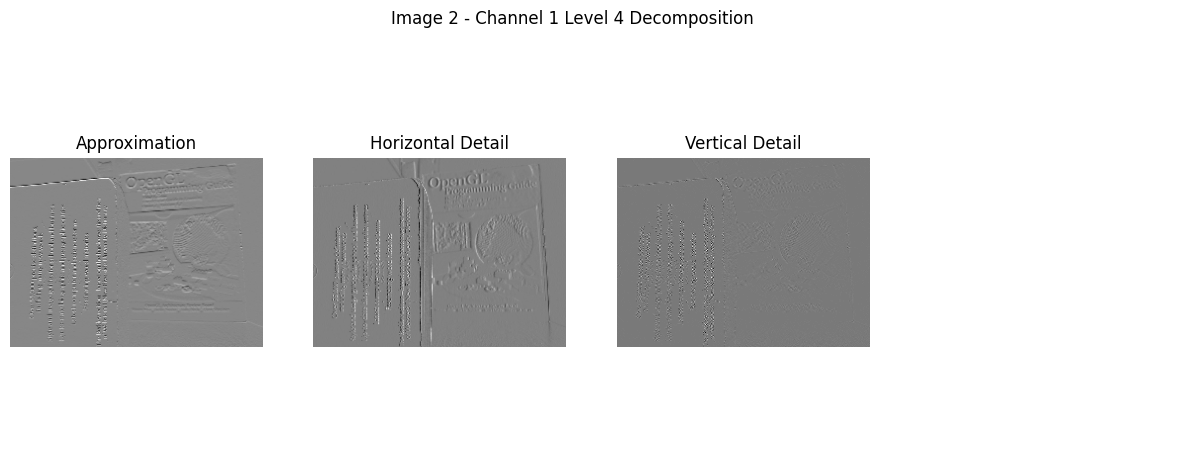

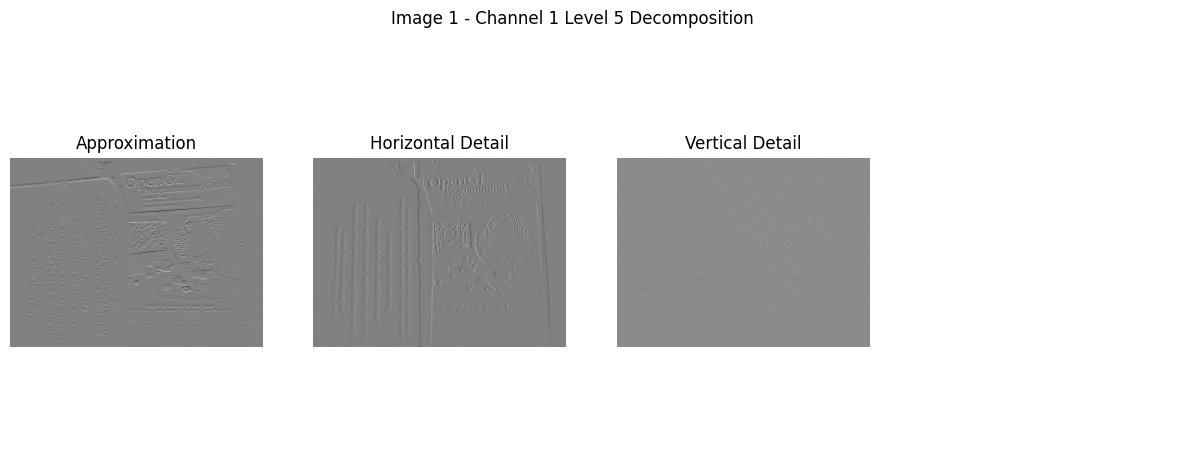

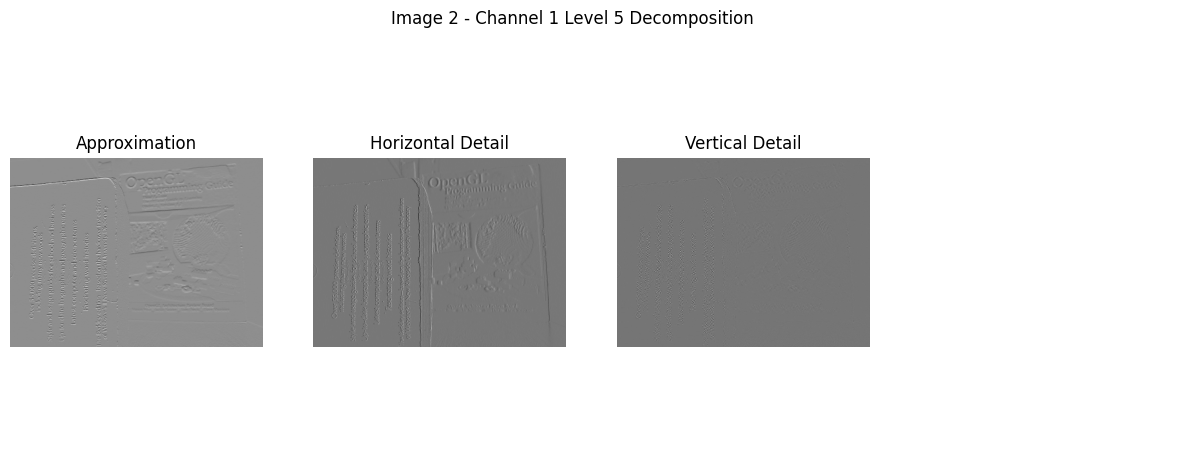

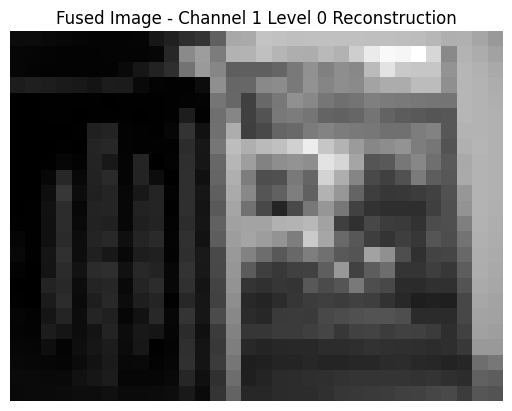

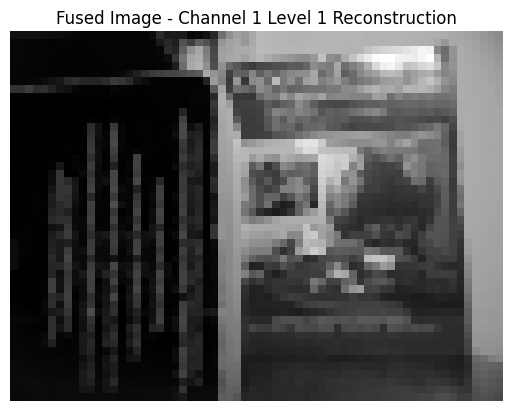

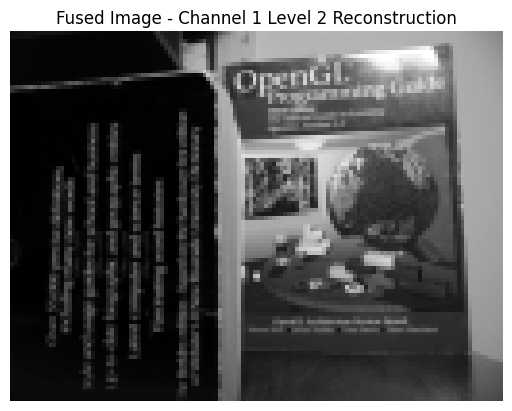

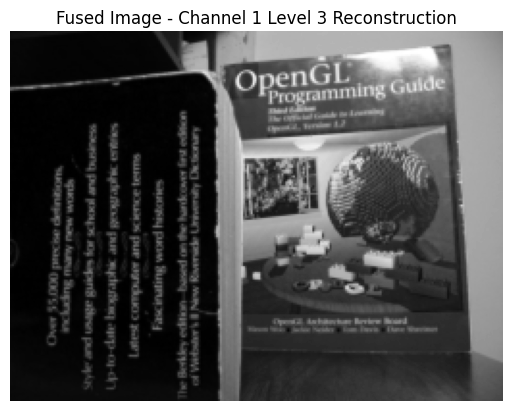

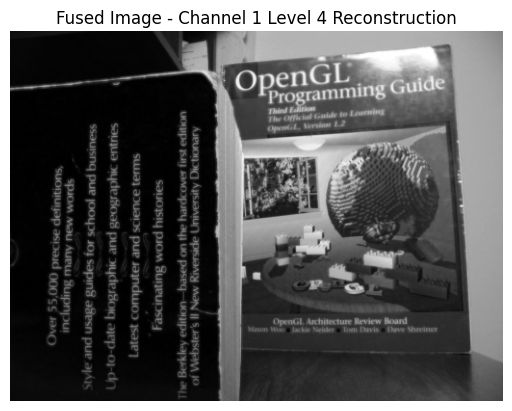

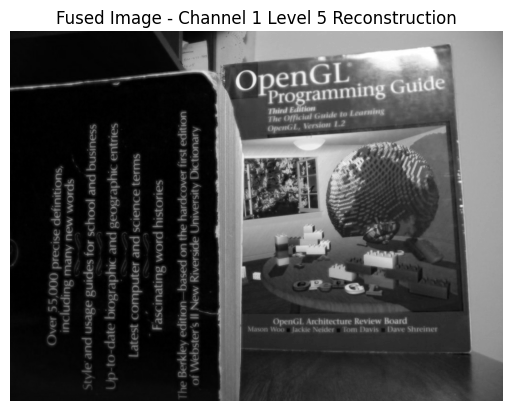

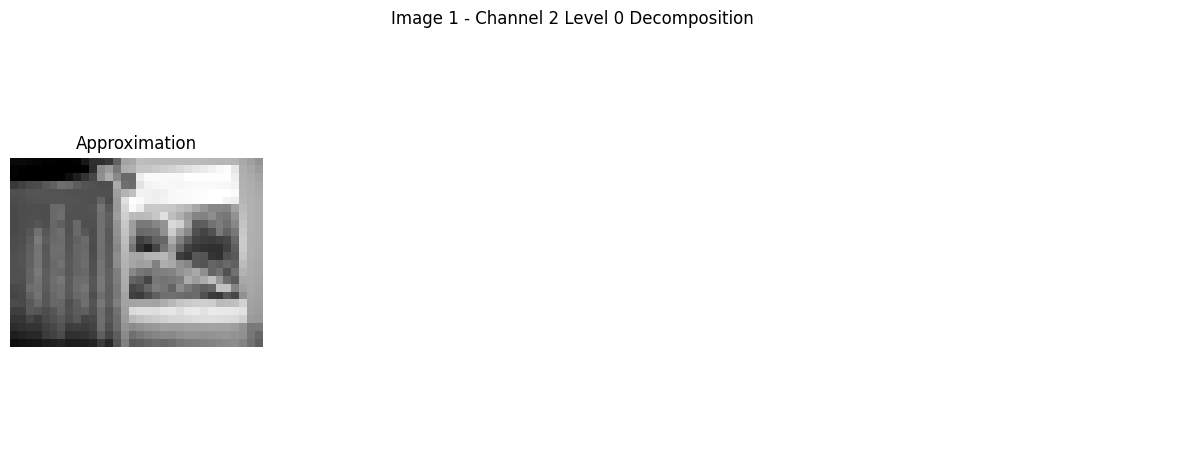

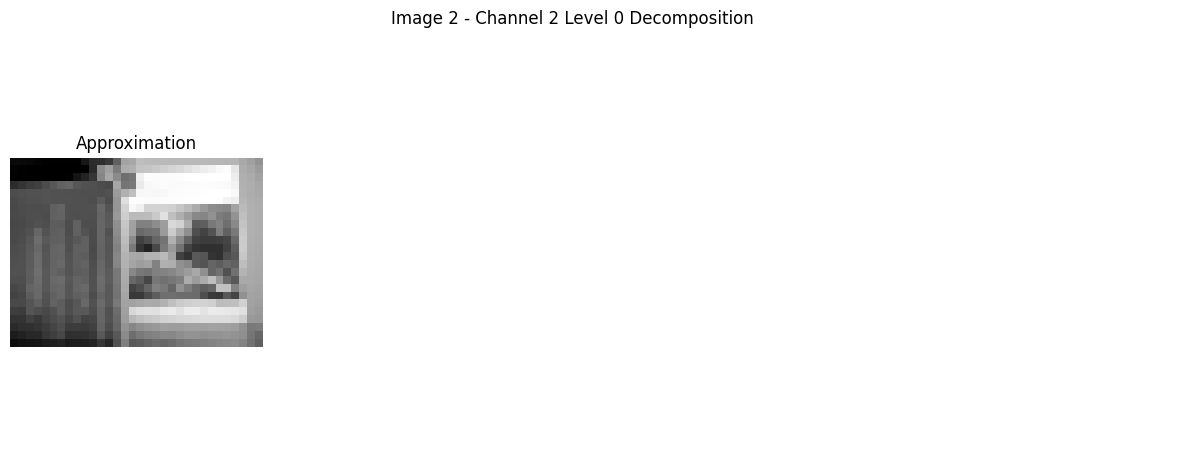

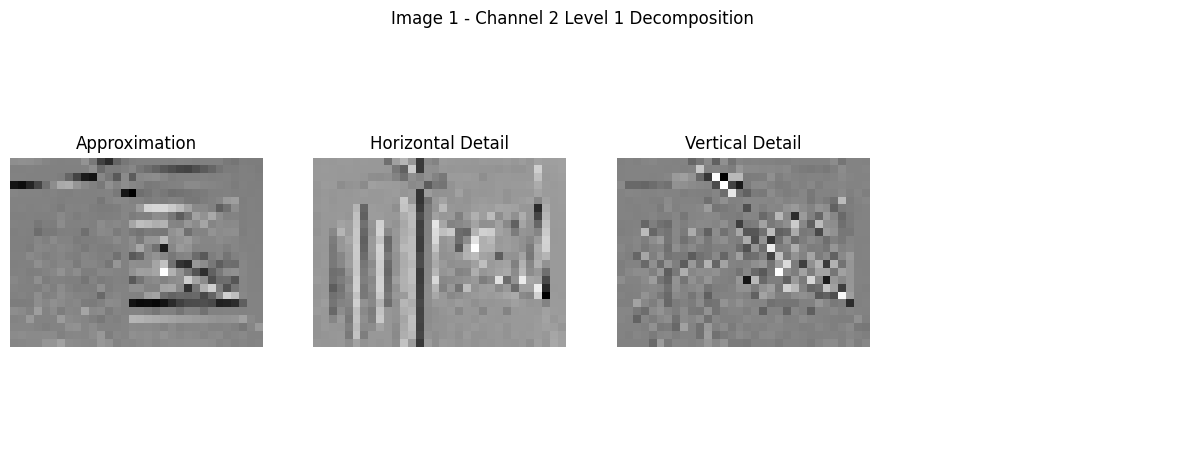

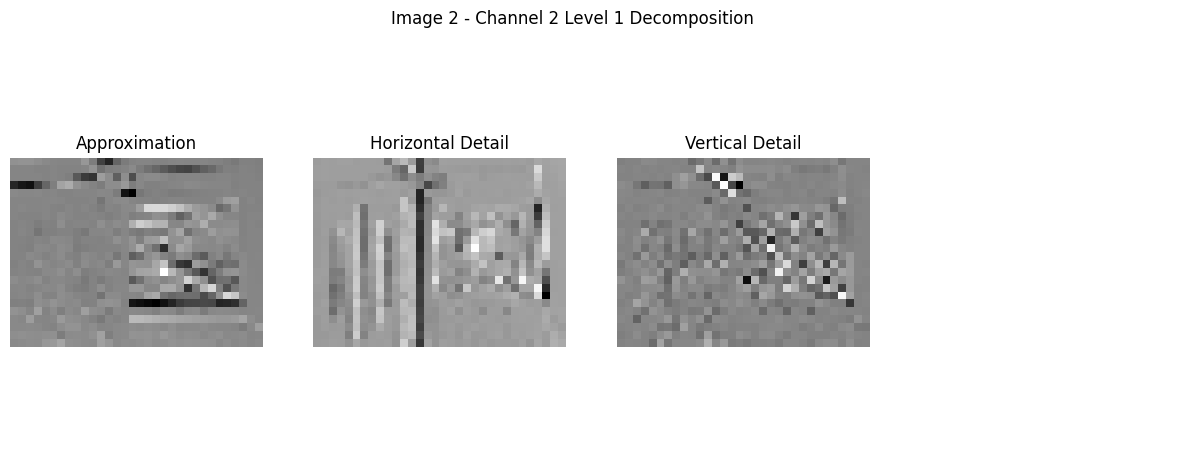

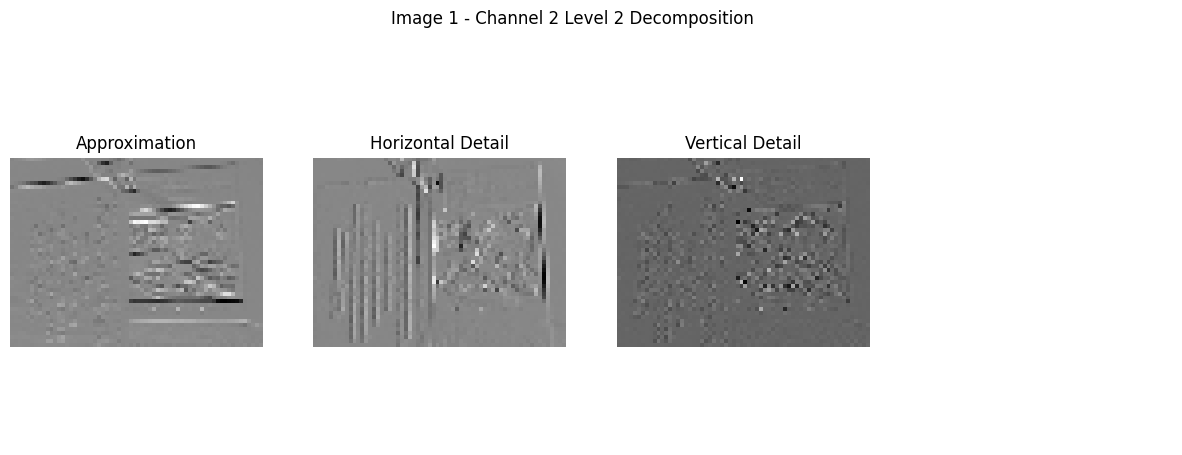

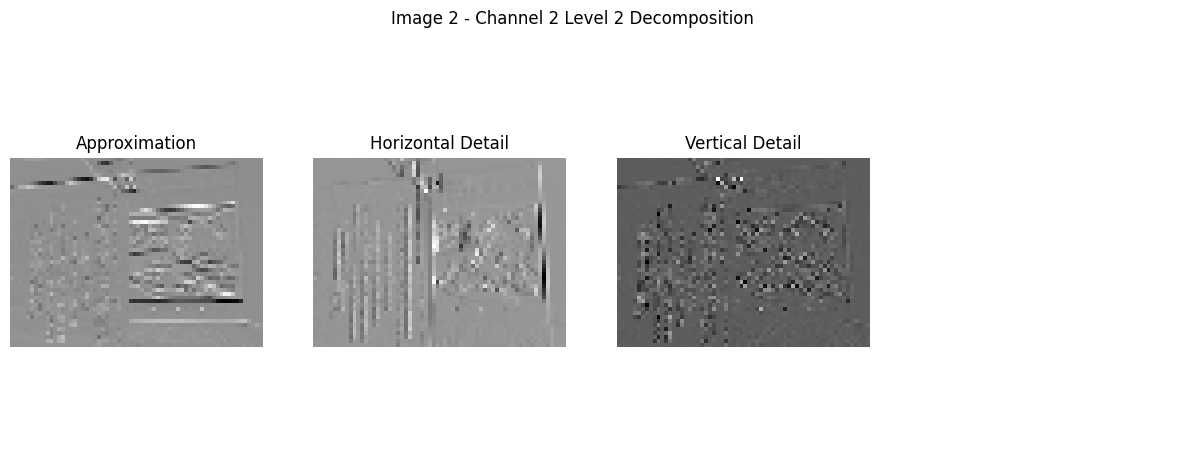

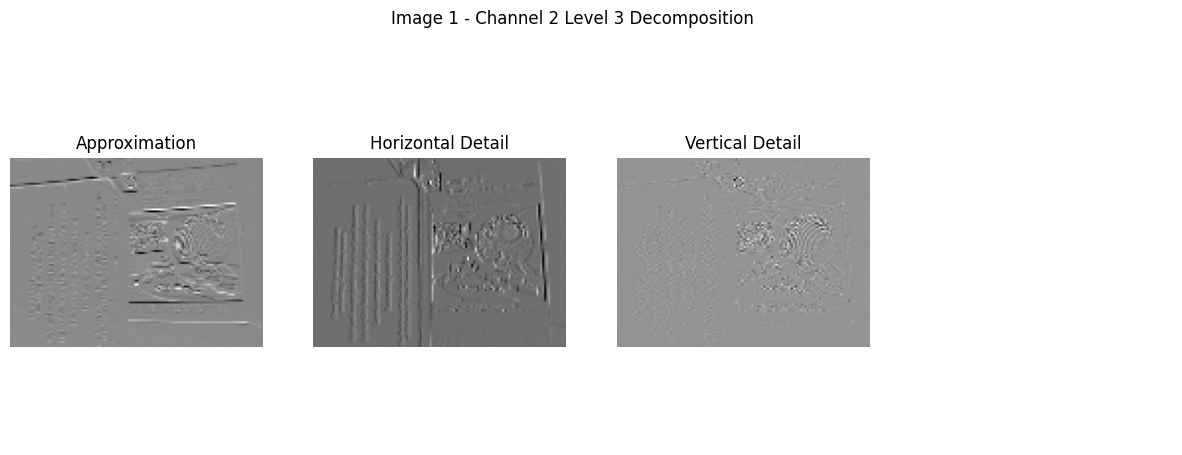

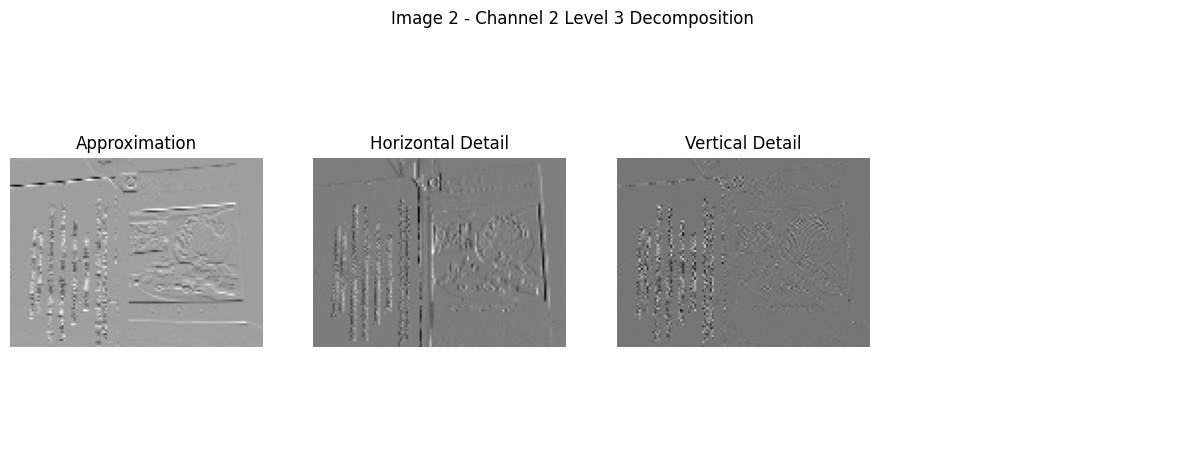

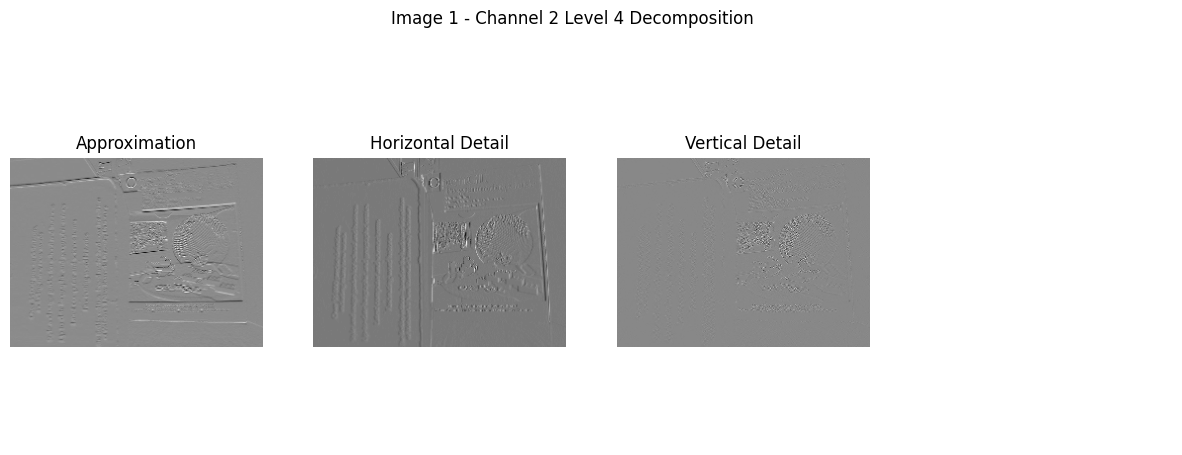

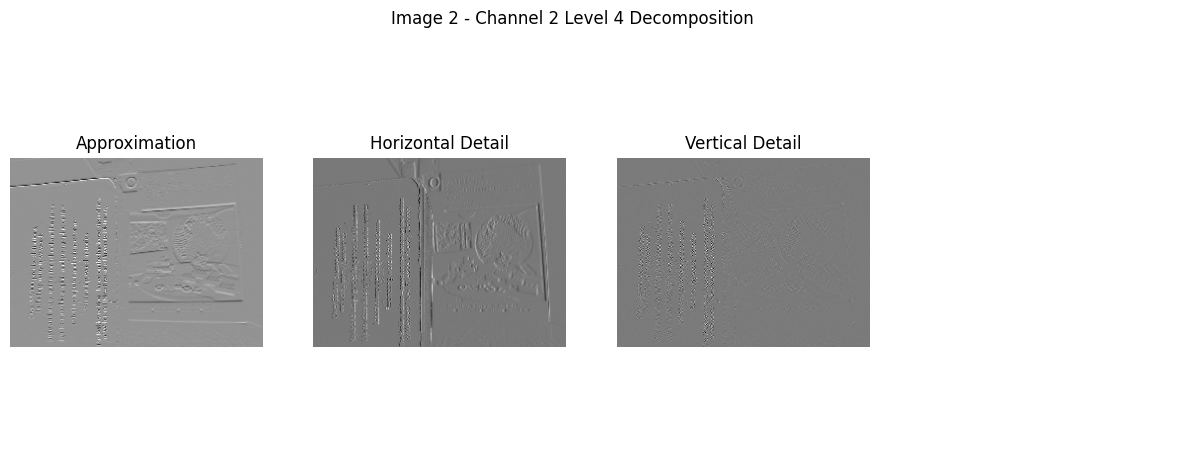

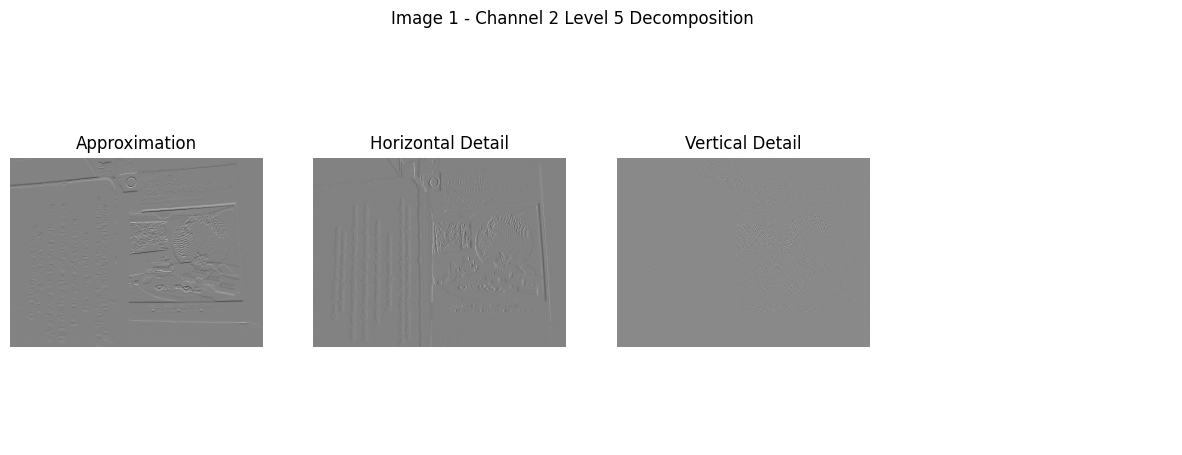

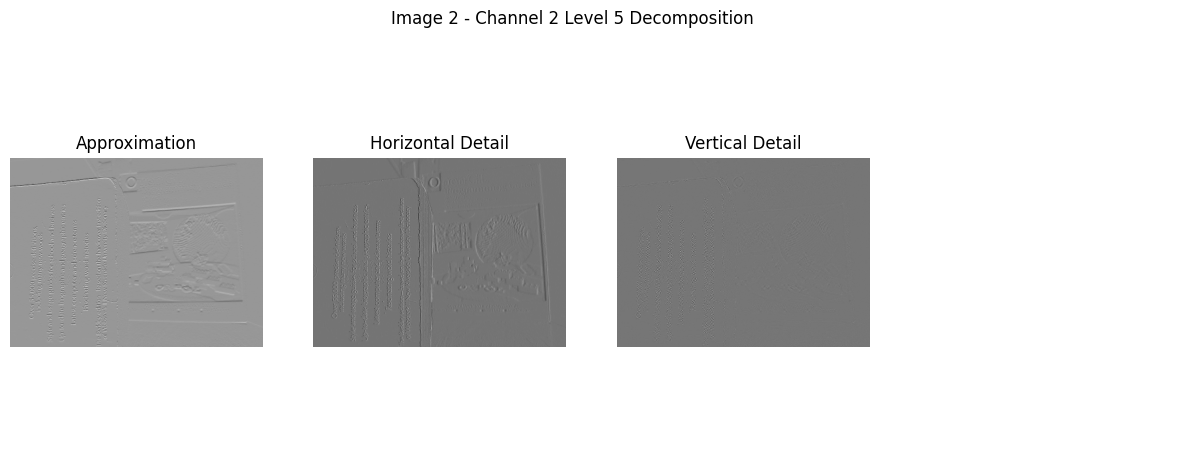

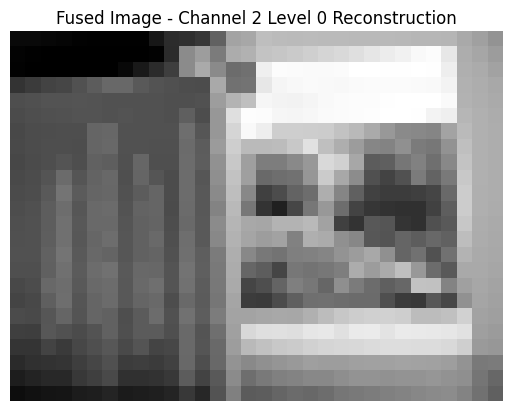

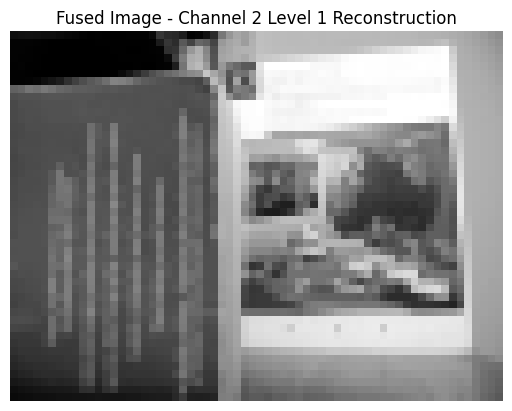

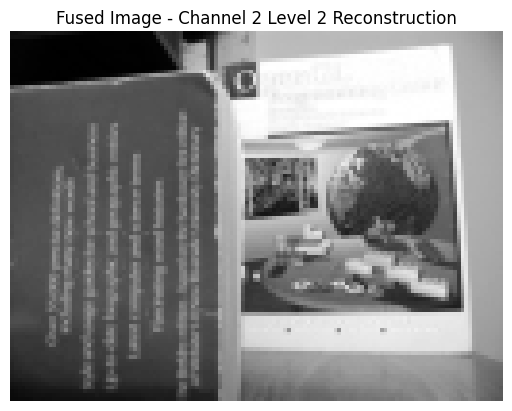

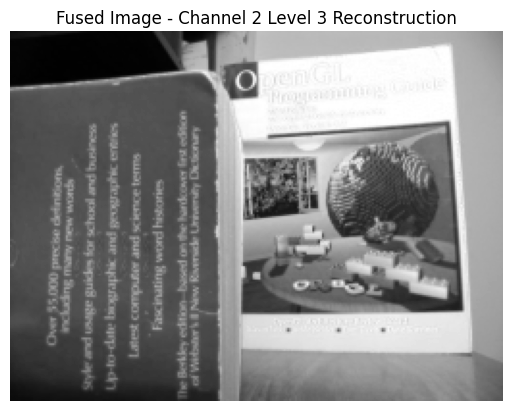

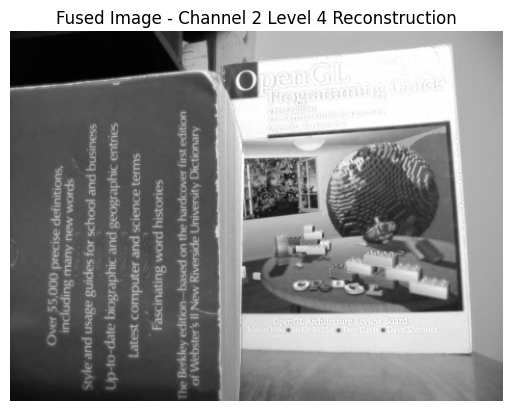

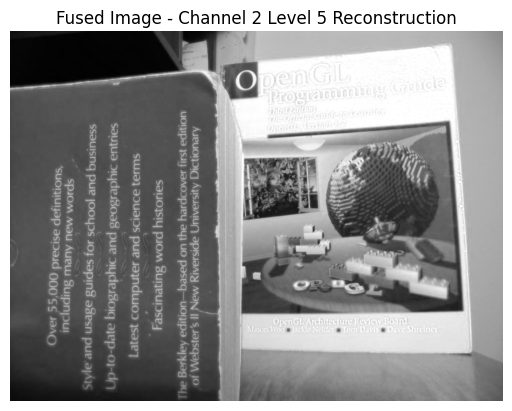

In [6]:
import pywt
import cv2
import numpy as np
import matplotlib.pyplot as plt


def fuseCoeff(cooef1, cooef2, method):
    if method == 'mean':
        cooef = (cooef1 + cooef2) / 2
    elif method == 'min':
        cooef = np.minimum(cooef1, cooef2)
    elif method == 'max':
        cooef = np.maximum(cooef1, cooef2)
    else:
        cooef = []
    return cooef


def plot_decomposition(coeffs, title):
    """Plots wavelet decomposition coefficients."""
    fig, axs = plt.subplots(1, 4, figsize=(15, 5))
    fig.suptitle(title)

    # Approximation (low-frequency content)
    axs[0].imshow(coeffs[0], cmap='gray')
    axs[0].set_title("Approximation")

    # Horizontal, Vertical, Diagonal details
    detail_titles = ["Horizontal Detail", "Vertical Detail", "Diagonal Detail"]
    for i, detail in enumerate(coeffs[1:]):
        axs[i + 1].imshow(detail, cmap='gray')
        axs[i + 1].set_title(detail_titles[i])

    for ax in axs:
        ax.axis('off')
    plt.show()


# Parameters
FUSION_METHOD = 'mean'
wavelet = 'db1'

# Load images
I1 = cv2.imread('book1.jpg', cv2.IMREAD_COLOR)
I2 = cv2.imread('book2.jpg', cv2.IMREAD_COLOR)

if I1 is None or I2 is None:
    print("Error: Images could not be loaded. Check file paths.")
    exit()

# Resize I2 to match I1
I2 = cv2.resize(I2, (I1.shape[1], I1.shape[0]))

# Process each color channel (B, G, R)
fused_channels = []
for channel in range(3):
    # Wavelet decomposition
    cooef1 = pywt.wavedec2(I1[:, :, channel], wavelet, level=5)
    cooef2 = pywt.wavedec2(I2[:, :, channel], wavelet, level=5)

    # Display decomposition for both images
    for level in range(len(cooef1)):
        if level == 0:
            plot_decomposition([cooef1[level]], f"Image 1 - Channel {channel} Level {level} Decomposition")
            plot_decomposition([cooef2[level]], f"Image 2 - Channel {channel} Level {level} Decomposition")
        else:
            plot_decomposition(
                [cooef1[level][0], cooef1[level][1], cooef1[level][2]],
                f"Image 1 - Channel {channel} Level {level} Decomposition",
            )
            plot_decomposition(
                [cooef2[level][0], cooef2[level][1], cooef2[level][2]],
                f"Image 2 - Channel {channel} Level {level} Decomposition",
            )

    # Fusion
    fusedCooef = []
    for i in range(len(cooef1)):
        if i == 0:  # Approximation coefficients
            fusedCooef.append(fuseCoeff(cooef1[0], cooef2[0], FUSION_METHOD))
        else:  # Detail coefficients
            c1 = fuseCoeff(cooef1[i][0], cooef2[i][0], FUSION_METHOD)
            c2 = fuseCoeff(cooef1[i][1], cooef2[i][1], FUSION_METHOD)
            c3 = fuseCoeff(cooef1[i][2], cooef2[i][2], FUSION_METHOD)
            fusedCooef.append((c1, c2, c3))

        # Reconstruction at the current level
        reconstructed = pywt.waverec2(fusedCooef, wavelet)
        plt.imshow(reconstructed, cmap='gray')
        plt.title(f"Fused Image - Channel {channel} Level {i} Reconstruction")
        plt.axis('off')
        plt.show()

    # Reconstruct final fused channel
    fused_channel = pywt.waverec2(fusedCooef, wavelet)
    fused_channels.append(fused_channel)

# Merge fused channels
fusedImage = cv2.merge(fused_channels)

# Normalize fused image to uint8
fusedImage = np.multiply(np.divide(fusedImage - np.min(fusedImage), (np.max(fusedImage) - np.min(fusedImage))), 255)
fusedImage = fusedImage.astype(np.uint8)

# Display final fused image
cv2.imshow("Fused Image", fusedImage)
cv2.waitKey(0)
cv2.destroyAllWindows()
